# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [2]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [3]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    if r.status_code == 200:  # Ensure the request was successful
        with open(file_path, 'wb') as f:
            f.write(r.content)
    else:
        print(f"Failed to download file. Status code: {r.status_code}")

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'shakespeare.txt'

# Correct raw URL for the text file
url = 'https://raw.githubusercontent.com/lookatme818/deep_learning/main/02_activities/assignments/downloaded_books/' + dataset

# Download and load the dataset
download_file(url, dataset)
text = load_dataset(dataset, fraction=0.01)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [4]:
# Your code here
print("First 1000 characters of the dataset:")
print(text[:1000])

First 1000 characters of the dataset:
The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For this

In [5]:
# Report the dataset size
dataset_size = len(text)
print("\nDataset size:", dataset_size)
# Number of unique characters
unique_characters = set(text)
num_unique_characters = len(unique_characters)
print('num_unique_characters:', num_unique_characters)


Dataset size: 93588
num_unique_characters: 96


## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Your code here
VOCAB_SIZE = 10000
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN, char_level=False)
text_lower = text.lower()
tokenizer.fit_on_texts([text_lower])

sequences = tokenizer.texts_to_sequences([text_lower])[0]
print(f'Number of unique tokens:{len(sequences)}')

Number of unique tokens:15393


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [7]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('to', 3), ('and', 4), ('of', 5), ('i', 6), ('a', 7), ('in', 8), ('my', 9), ('footnote', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [8]:
SEQ_LENGTH = 5 # Choose an appropriate sequence length
import numpy as np
# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text_lower])[0]  # Flattened list of tokenized text

# Generate the training sequences
X = []
y = []

# Slide a window of SEQ_LENGTH + 1 over the tokenized text
for i in range(len(sequences) - SEQ_LENGTH):
    seq = sequences[i : i + SEQ_LENGTH + 1]  # Includes SEQ_LENGTH + 1 tokens
    X.append(seq[:-1])  # First SEQ_LENGTH tokens as input
    y.append(seq[-1])   # Last token as the target

# Convert X and y to NumPy arrays
X = np.array(X)
y = np.array(y)

# Display the result
print(f"Number of training sequences: {len(X)}")
print(f"First training sequence (input): {X[0]}")
print(f"Target word for first sequence: {y[0]}")

Number of training sequences: 15388
First training sequence (input): [  2 606 461 366   5]
Target word for first sequence: 45


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [9]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [  2 606 461 366   5]
Target: 45
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of'] -> hamlet


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (12310, 5)
y_train shape: (12310, 10000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential([
   # Embedding layer
    Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=SEQ_LENGTH),
    # LSTM layer
    LSTM(128, return_sequences=False),
    # Dense layer with softmax activation for classification
    Dense(VOCAB_SIZE, activation='softmax')
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [13]:
# Your code here
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Explanation:
The model uses the categorical crossentropy loss function, which is ideal for multi-class classification tasks like predicting the next word from a vocabulary, as it compares the predicted probability distribution to the one-hot encoded target. The Adam optimizer is chosen for its efficiency and ability to adapt learning rates, requiring minimal hyperparameter tuning while handling sparse gradients effectively. Additionally, accuracy is tracked as a metric to monitor the proportion of correct predictions, providing an intuitive measure of the model's performance during training and validation.

## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [14]:
# Your code here
history = model.fit(X, y, epochs=5, batch_size=128, validation_split=0.1,verbose=1  )


Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0331 - loss: 8.4885 - val_accuracy: 0.0546 - val_loss: 7.0875
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0414 - loss: 6.5635 - val_accuracy: 0.0546 - val_loss: 7.1098
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0408 - loss: 6.4112 - val_accuracy: 0.0104 - val_loss: 7.1707
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0374 - loss: 6.3135 - val_accuracy: 0.0546 - val_loss: 7.1790
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0397 - loss: 6.2947 - val_accuracy: 0.0370 - val_loss: 7.2329


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

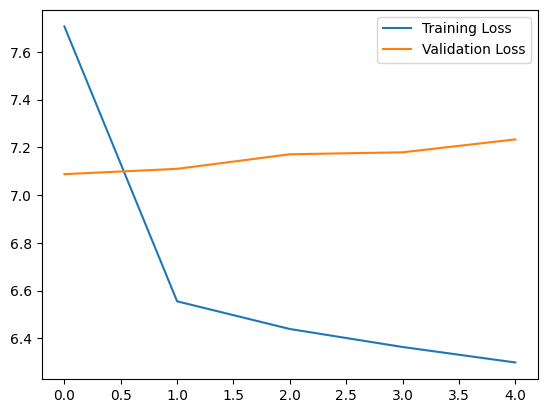

In [15]:
import matplotlib.pyplot as plt

# Your code here
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show('LOSS')

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [16]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model using a temperature-based approach for randomness.
    """
    # Predict probabilities for the next token
    yhat = model.predict(sequence, verbose=0)

    # Use randomness to select the next word based on the probabilities
    predicted_index = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return predicted_index

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words=50):
    """
    Generate new text using the trained model.

    Parameters:
    - model: Trained RNN model.
    - tokenizer: Tokenizer used to preprocess the text data.
    - seed_text: Initial text to start generating text from.
    - max_sequence_len: Maximum length of the input sequence.
    - num_words: Number of words to generate (default: 50).

    Returns:
    - Generated text as a string.
    """
    # Initialize the result with the seed text
    generated_text = seed_text

    # Generate the desired number of words
    for _ in range(num_words):
        # Tokenize the current seed text
        token_list = tokenizer.texts_to_sequences([generated_text])[0]

        # Pad the sequence to the required length
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

        # Predict the next word using the helper function
        predicted_index = get_predicted_word(model, token_list)

        # Convert the token ID to the corresponding word
        predicted_word = tokenizer.index_word.get(predicted_index, "<OOV>")

        # Stop if the predicted word is OOV
        if predicted_word == "<OOV>":
            break

        # Add the predicted word to the generated text
        generated_text += " " + predicted_word

    return generated_text



In [17]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet to twelve the spent be close as'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [18]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-04 05:26:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.09MB/s    in 2m 40s  

2024-12-04 05:29:07 (5.15 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [19]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [20]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [21]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

In [22]:
# Define a new model and train it

# Your code here
from keras.optimizers import Adam
from keras.layers import Dropout

model = Sequential([
    embedding_layer,
    LSTM(100),
    Dropout(0.2),
    Dense(VOCAB_SIZE, activation='softmax')
])

model.layers[0].trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [23]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=5, batch_size=32)

Epoch 1/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0391 - loss: 7.4126 - val_accuracy: 0.0642 - val_loss: 6.6482
Epoch 2/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0789 - loss: 6.1934 - val_accuracy: 0.0780 - val_loss: 6.6178
Epoch 3/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0892 - loss: 5.6767 - val_accuracy: 0.0837 - val_loss: 6.7276
Epoch 4/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1244 - loss: 5.0856 - val_accuracy: 0.0788 - val_loss: 6.8629
Epoch 5/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.1635 - loss: 4.5117 - val_accuracy: 0.0885 - val_loss: 7.0168


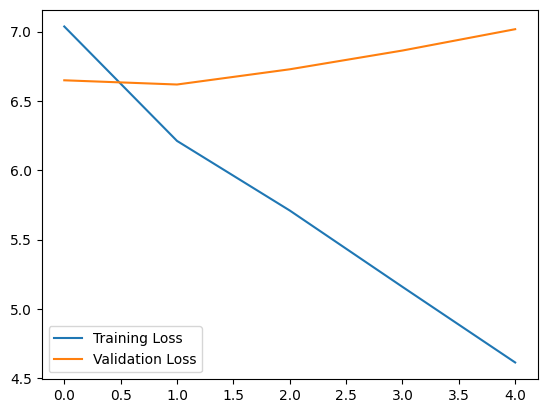

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show('LOSS')

In [25]:
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet o trumpet a room so these you e folded at whom me mercy the shape more 102 and make forward you will we business the ourselves made tender yourself thee along that wherefore comes westward from thy thoughts own articulation as must to stand on him thaw all offal bloody'

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.